In [36]:
from check_decoding import *

In [2]:
PATHS.data = Path('/home/is153802/workspace_LPP/data/MEG/LPP/BIDS_lecture')

In [3]:
bids_path = mne_bids.BIDSPath(
            subject='1',
            session="01",
            task='listen',
            datatype="meg",
            root=PATHS.data,
            run='01',
        )

In [4]:
run_id = '01'
raw = mne_bids.read_raw_bids(bids_path)
raw.pick_types(meg=True, stim=True)
raw.load_data()
raw = raw.filter(0.5, 20)

event_file = PATHS.data / f"sub-{bids_path.subject}"
event_file = event_file / f"ses-{bids_path.session}"
event_file = event_file / "meg"
event_file = str(event_file / f"sub-{bids_path.subject}")
event_file += f"_ses-{bids_path.session}"
event_file += f"_task-{bids_path.task}"
event_file += f"_run-{bids_path.run}_events.tsv"
assert Path(event_file).exists()
# read events
meta = pd.read_csv(event_file, sep="\t")
events = mne.find_events(
    raw, stim_channel="STI101", shortest_event=1, min_duration=0.0010001
)



/tmp/ipykernel_1846648/144404254.py:2: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_1846648/144404254.py:2: RuntimeWarning: Omitted 4 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_1846648/144404254.py:2: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


In [12]:
word_length_meg = events[:,2]
word_length_meta = meta.word.apply(len)
i,j = match_list(word_len_meta,word_length_meg)


In [16]:
run_id = '01'
print(f"Len i : {len(i)} for run {run_id}")
assert len(i) > 500
events = events[i]
# events = events[i]  # events = words_events[i]
meta = meta.iloc[j].reset_index()

meta['start'] = events[:,0]/raw.info['sfreq']

Len i : 1411 for run 01


In [19]:
epochs = mne.Epochs(
    raw, events, metadata=meta, tmin=-0.1, tmax=0.6, decim=20, baseline=(-0.1, 0.0)
)

/tmp/ipykernel_1846648/1721045210.py:1: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


In [20]:
epochs.load_data()
epochs = epochs.pick_types(meg=True,stim=False,misc=False)

In [32]:
def decod(X, y):
    assert len(X) == len(y)
    # define data
    model = make_pipeline(StandardScaler(), RidgeCV(alphas=np.logspace(-3, 8, 10)))
    cv = KFold(15, shuffle=True, random_state=0)

    # fit predict
    n, n_chans, n_times = X.shape
    if y.ndim == 1:
        y = np.asarray(y).reshape(y.shape[0],1)
    R = np.zeros((n_times, y.shape[1]))
    
    for t in range(n_times):
        print(".", end="")
        rs = []
        # y_pred = cross_val_predict(model, X[:, :, t], y, cv=cv)
        for train, test in cv.split(X):
            model.fit(X[train,:,t],y[train])
            y_pred = model.predict(X[test,:,t])
            r = correlate(y[test],y_pred)
            rs.append(r)
        R[t] = np.mean(rs)    
        #R[t] = correlate(y, y_pred)
        
    return R



In [22]:

X = epochs.get_data()
y = epochs.metadata.word.apply(len)


In [33]:
R = decod(X,y)

....................................

In [25]:
%matplotlib inline

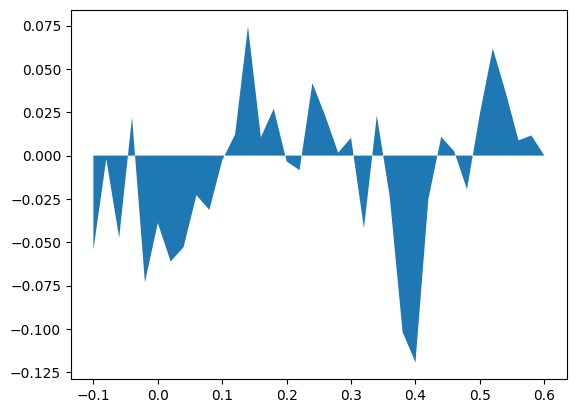

In [35]:
plt.fill_between(epochs.times,np.squeeze(R))

In [32]:
evoked = epochs.average(method='median')

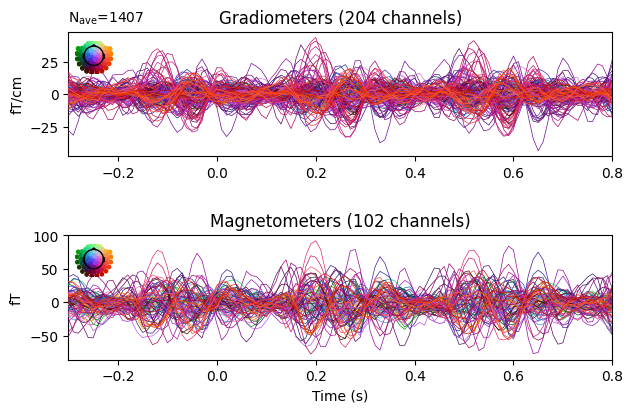

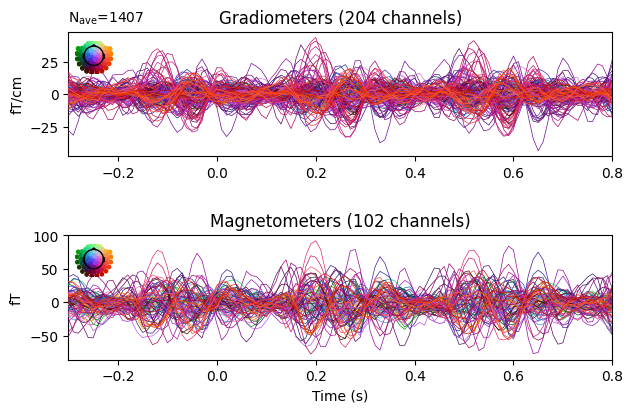

In [33]:
evoked.plot()

In [35]:
epochs.metadata['trigger_value'] = epochs.events[:,2]

In [31]:
epochs.metadata.iloc[:40]

,index,Unnamed: 0,word,onset,duration,trial_type,start
0,1,1,j'avais,1.05,0.3,"{'kind': 'word', 'word': 'javais'}",43.914
1,2,2,six,1.40,0.3,"{'kind': 'word', 'word': 'six'}",44.534
2,3,3,"ans,",1.75,0.3,"{'kind': 'word', 'word': 'ans'}",44.889
3,4,4,j'ai,2.10,0.3,"{'kind': 'word', 'word': 'jai'}",45.189
4,5,5,"vu,",2.45,0.3,"{'kind': 'word', 'word': 'vu'}",45.489
5,6,6,une,2.80,0.3,"{'kind': 'word', 'word': 'une'}",45.806
6,7,7,"fois,",3.15,0.3,"{'kind': 'word', 'word': 'fois'}",46.122
7,8,8,une,3.50,0.3,"{'kind': 'word', 'word': 'une'}",46.439
8,9,9,magnifique,3.85,0.3,"{'kind': 'word', 'word': 'magnifique'}",46.756
9,10,10,"image,",4.20,0.3,"{'kind': 'word', 'word': 'image'}",47.072
